In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c2 = np.max([model.optimizer.C2[1] - ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[0]])
    model.optimizer.c1 = np.min([model.optimizer.C1[0] + ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.9320987654320988, Loss: 0.23623549496686017
Checkpoint 200, Accuracy: 0.9691358024691358, Loss: 0.12305660601015445
Checkpoint 300, Accuracy: 0.9629629629629629, Loss: 0.10813041969581887
Checkpoint 400, Accuracy: 0.9753086419753086, Loss: 0.10192155838012695
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.10111130608452691


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.996911   0.00165232 0.00143663]
[1. 0. 0.] <-> [0.99440336 0.00126435 0.00433222]
[0. 0. 1.] <-> [7.303630e-03 8.758310e-06 9.926876e-01]
[1. 0. 0.] <-> [0.99661946 0.00182886 0.00155166]
[1. 0. 0.] <-> [0.99723685 0.00147134 0.00129177]
[1. 0. 0.] <-> [0.992863   0.00250434 0.00463268]
[1. 0. 0.] <-> [0.9878249  0.00119927 0.01097587]
[1. 0. 0.] <-> [0.99642    0.00142064 0.00215936]
[1. 0. 0.] <-> [0.9969382  0.00133427 0.00172758]
[1. 0. 0.] <-> [0.99570554 0.00275294 0.00154155]
[1. 0. 0.] <-> [0.99730384 0.00124541 0.0014507 ]
[1. 0. 0.] <-> [0.9928308  0.00119913 0.00597005]
[1. 0. 0.] <-> [0.99641365 0.00243905 0.00114736]
[1. 0. 0.] <-> [0.997072   0.00137475 0.00155326]
[1. 0. 0.] <-> [1.0246844e-01 1.2423539e-04 8.9740729e-01]
[0. 0. 1.] <-> [7.5361840e-03 9.0344593e-06 9.9245477e-01]
[0. 1. 0.] <-> [1.5612230e-02 9.8404747e-01 3.4028332e-04]
[1. 0. 0.] <-> [0.99706465 0.00174383 0.00119153]
[1. 0. 0.] <-> [0.11238291 0.886423   0.00119402]
[0. 1. 0.] <-> [4

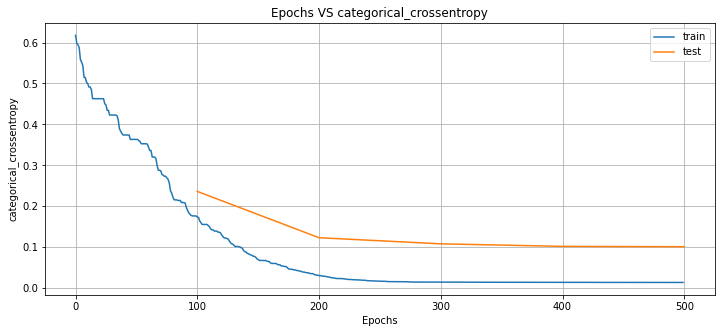

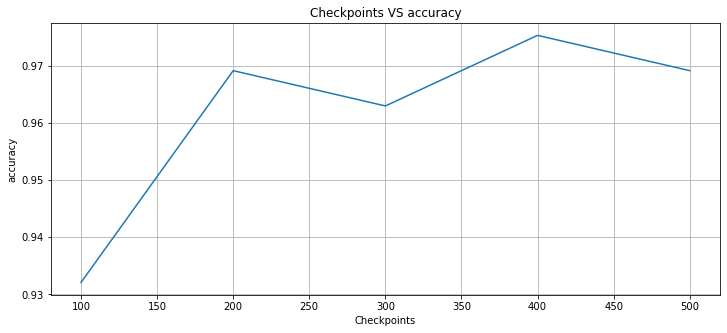

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9320987654320988, 'mean_square_error': 0.1317219764127375, 'categorical_crossentropy': 0.23623549496686017, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 10, 'tn_hit': 20, 'fn_hit': 1}, 1: {'tp_hit': 14, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 2}, 2: {'tp_hit': 6, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 8}}, 'checkpoint': 100} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.07009322619771205, 'categorical_crossentropy': 0.12305660601015445, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 3, 'tn_hit': 27, 'fn_hit': 2}, 1: {'tp_hit': 14, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 2}, 2: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 1}}, 'checkpoint': 200} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.06821068778561247, 'categorical_crossentropy': 0.10813041969581887, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 3, 'tn_hit': 27, 'fn_hit': 3}, 1: {'tp_hit': 15, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 1}, 2: {'tp_hit': 12, 'fp_hit': 1, 'tn_hit': 93, 

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-0.2154944   3.          0.23579189 -1.5613998  -3.        ]
 bias: 2.3585166931152344

Neuron 1: weights:
[-2.0556269   3.          3.         -0.18882886 -0.8931402 ]
 bias: -3.0

Neuron 2: weights:
[ 1.8838887  -3.         -3.          0.22727078  2.2151775 ]
 bias: 3.0

Neuron 3: weights:
[-0.31752157 -3.         -0.11559141  0.9242965   3.        ]
 bias: -2.4186084270477295

$
Layer 2
Neuron 0: weights:
[ 3. -3.  3. -3.]
 bias: 1.9164608716964722

Neuron 1: weights:
[ 3.  3. -3. -3.]
 bias: 1.190034031867981

Neuron 2: weights:
[-3.         0.6992921  3.         3.       ]
 bias: 0.8284657001495361

$

